In [1]:
# import csv
import torch
import pandas as pd
import myKit
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from d2l import torch as d2l

"""获取数据集"""

total_df = pd.read_csv("E:\GitCode\BoneAgeAss-main\data/archive/boneage-training-dataset.csv")
valid_df = pd.read_csv('./valid_6_6.csv')
valid_dataset = myKit.BAAValDataset(valid_df)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size = 10,
    shuffle = True,
    drop_last = True
)
train_df = pd.read_csv('./train_6_6.csv')
train_dataset = myKit.BAAValDataset(train_df)
train_sampler = torch.utils.data.RandomSampler(
    train_dataset,
    False,
    100
)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, sampler=train_sampler, batch_size=10)
for idx, data in enumerate(train_loader):
    print("idx=", idx, ". labels=", data[1])

idx= 0 . labels= tensor([150,  96, 162, 106,  18,  94, 108, 132, 138, 106])
idx= 1 . labels= tensor([ 50, 132,  72, 168, 106, 216,  88,  48, 168,  75])
idx= 2 . labels= tensor([228, 210,  16,  54, 216,  96, 132, 106, 156, 150])
idx= 3 . labels= tensor([222,  42, 210,  48, 138,  12,  10, 216,  18,  84])
idx= 4 . labels= tensor([ 60, 210,  24, 165,  36,  84,  18, 162,  96, 126])
idx= 5 . labels= tensor([132, 186, 192, 108, 132,  21,  33,  69, 106, 168])
idx= 6 . labels= tensor([ 54, 132,   1,  82,  60, 186, 210, 216, 192,  18])
idx= 7 . labels= tensor([ 15, 216,  42, 216, 108, 216, 222,  18, 162, 108])
idx= 8 . labels= tensor([216,  69,  24, 228, 228,   4,  21,  90, 216, 162])
idx= 9 . labels= tensor([ 36, 180,  82, 204, 120, 132, 150, 120, 216, 210])


In [2]:
# print(len(total_df))
boneage_mean = total_df['boneage'].mean()
boneage_div = total_df['boneage'].std()
print("Boneage_mean: ", boneage_mean, ". Boneage_div: ", boneage_div)

Boneage_mean:  127.3207517246848 . Boneage_div:  41.182021399396326


获取模型

In [3]:
net = torch.load('./model_without_penalty.pth')
device = myKit.try_gpu()
net = net.to(device)

引入罚函数penalty

In [4]:
def L1_penalty(net, alpha):
    # l1_penalty = torch.nn.L1Loss(size_average = False)
    loss = 0
    for param in net.MLP.parameters():
        loss += torch.sum(torch.abs(param))
    return alpha*loss

定义验证函数，获取网络的中间输出以及尾部输出

In [5]:
def evaluate_MMCA(data_iter, net, devices):
    net.eval()
    pred_list = torch.zeros((1,))
    # pred_list = torch.zeros((1,))
    grand_age = torch.zeros((1,))
    mae_loss = torch.tensor([0], dtype=torch.float32)
    val_total_size = torch.tensor([0], dtype=torch.float32)
    class_loss = torch.zeros((230, 1))
    class_num = torch.zeros((230, 1))
    last_pics = None
    with torch.no_grad():
        for batch_idx, data in enumerate(data_iter):
            val_total_size += len(data[1])
            image, gender = data[0]
            image, gender = image.type(torch.FloatTensor).to(devices), gender.type(torch.FloatTensor).to(devices)
            if (batch_idx + 1) == len(data_iter):
                last_pics = image.cpu()
            label = data[1].type(torch.FloatTensor).to(devices)
            AM1, AM2, AM3, AM4, y_pred = net(image, gender)
            # y_pred = net(image, gender)
            y_pred = y_pred.cpu()
            label = label.cpu()
            y_pred = y_pred * boneage_div + boneage_mean
            # print(y_pred.shape)
            y_pred = y_pred.squeeze()
            pred_list = torch.cat([pred_list, y_pred], dim=0)
            grand_age = torch.cat([grand_age, label], dim=0)
            # y_pred = y_pred.argmax(axis=1).type(torch.FloatTensor)
            # y_pred = y_pred.squeeze()
            batch_loss = F.l1_loss(y_pred, label.long(), reduction='none')
            for i in range(label.shape[0]):
                class_loss[int(label[i])] += batch_loss[i]
                class_num[int(label[i])] += 1
            batch_loss = batch_loss.sum().item()
            mae_loss += batch_loss

    myKit.loss_map(class_loss, class_num, 'MMCA_loss_map_6_5.png')
    accuracy_num = myKit.accuracy(pred_list[1:], grand_age[1:])
    # accuracy_num = torch.tensor([0], dtype=torch.float32)
    # for pred0, grand_true in zip(pred_list[1:], grand_age[1:]):
    #         y_hat = int(pred0.item())
    #         y = int(grand_true.item())
    #         print(f'{y_hat},   {y}')
    #         if y_hat==y:
    #             accuracy_num += 1
    print('------------------------------------------')
    print(f'val loss is {mae_loss / val_total_size}, accuracy : {accuracy_num / val_total_size}')
    return AM1, AM2, AM3, AM4, last_pics

def train_MMCA(data_iter, net, devices):
    net.eval()
    last_pics = None
    loss_fn = nn.L1Loss(reduction='sum')
    with torch.no_grad():
        for batch_idx, data in enumerate(data_iter):
            image, gender = data[0]
            image, gender = image.type(torch.FloatTensor).to(devices), gender.type(torch.FloatTensor).to(devices)
            if (batch_idx + 1) == len(data_iter):
                last_pics = image.cpu()
            label = data[1].type(torch.FloatTensor).to(devices)
            AM1, AM2, AM3, AM4, y_pred = net(image, gender)
            # y_pred = net(image, gender)
            y_pred = y_pred.cpu()
            label = label.cpu()
            loss = loss_fn(y_pred, label)
            # loss_penalty = L1_penalty(net, 1e-5)
    print('------------------------------------------')
    # print(f'loss is {loss}, L1_penalty : {loss_penalty}')
    print(f'loss is {loss}')
    return AM1, AM2, AM3, AM4, last_pics


In [6]:
unloader = torchvision.transforms.ToPILImage()
# AM1, AM2, AM3, AM4, last_pics = evaluate_MMCA(valid_loader, net, device)
AM1, AM2, AM3, AM4, last_pics = train_MMCA(train_loader, net, device)

d:\Anaconda\envs\BAA\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


------------------------------------------
loss is 11690.439453125


In [7]:
# AM = AM.cpu()
print("last_pics shape: ", last_pics.shape)
pics_gray = torch.mean(last_pics, dim=1)
AM = [pics_gray, AM1, AM2, AM3, AM4]
print("AM1:", AM1[0])
print("AM2:", AM2[0])

last_pics shape:  torch.Size([10, 3, 512, 512])
AM1: tensor([[[0.6191, 0.6177, 0.6155,  ..., 0.6155, 0.6155, 0.6155],
         [0.6155, 0.6155, 0.6155,  ..., 0.6155, 0.6155, 0.6022],
         [0.6155, 0.6155, 0.6155,  ..., 0.6155, 0.6155, 0.5977],
         ...,
         [0.6155, 0.6155, 0.6155,  ..., 0.6155, 0.6155, 0.6018],
         [0.6155, 0.6100, 0.6165,  ..., 0.6129, 0.6155, 0.6102],
         [0.6210, 0.6045, 0.6054,  ..., 0.6011, 0.6089, 0.6191]]],
       device='cuda:0')
AM2: tensor([[[0.4016, 0.3830, 0.3902,  ..., 0.3904, 0.3830, 0.3881],
         [0.3830, 0.3830, 0.3830,  ..., 0.3855, 0.3830, 0.3830],
         [0.4188, 0.4326, 0.4373,  ..., 0.3932, 0.3943, 0.3830],
         ...,
         [0.4081, 0.3830, 0.3904,  ..., 0.3913, 0.3971, 0.3858],
         [0.3830, 0.4257, 0.4324,  ..., 0.4187, 0.4004, 0.3830],
         [0.4465, 0.4163, 0.3838,  ..., 0.3830, 0.3867, 0.4086]]],
       device='cuda:0')


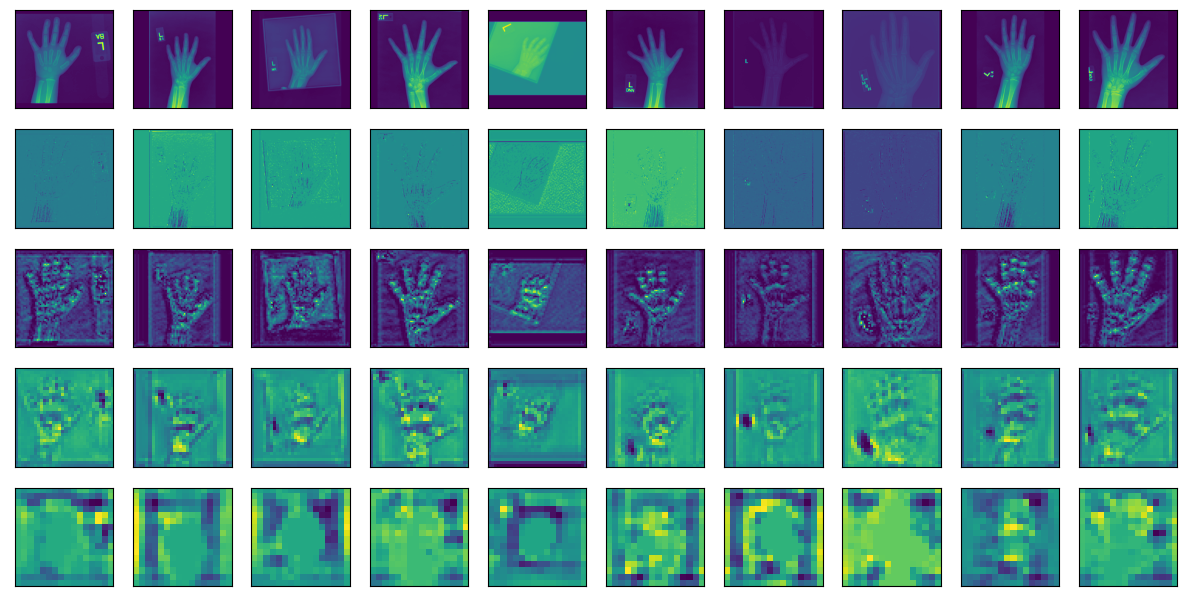

In [8]:
import matplotlib.pyplot as plt
images = []
# 定义打印图片的函数
def show_images(imgs, num_rows, num_cols, save_name, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img, cmap='gray')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    fig.savefig(save_name)
    return axes

def print_AM(AM, save_name):
    plt_pic = []
    for i in range(5):
        for j in range(AM[i].shape[0]):
            img = AM[i][j].squeeze().cpu()
            plt_pic.append(img)
    show_images(imgs=plt_pic, num_rows=5, num_cols=pics_gray.shape[0], save_name=save_name)

print_AM(AM, "Attention Map 6_5")